In [1]:
import ngsolve as ngs
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw
from ngsolve.krylovspace import CGSolver
from ttictoc import tic, toc

mesh = ngs.Mesh('whatever.vol')
mesh.Curve(2)
# mesh.Refine()
# ngs.ngsglobals.msg_level = 0
# ngs.SetHeapSize(100*1000*1000)

In [2]:
%run J.ipynb

using 3d mesh with ne= 5149  elements and nv= 1954  points
Solving...
Number of iterations = 354/1000 | Residual = 9.327682992351192e-06
999.9999999999961
Solving...
Number of iterations = 179/1000 | Residual = 9.814198710538383e-06
1000.000086044868


In [3]:
from bhdata import BHCurves
fun_dw  = BHCurves(-3)
fun_w   = fun_dw.Integrate()
fun_ddw = fun_dw.Differentiate()

mu0 = 1.256636e-6
nu0 = 1/mu0

linear = "coil|ambient|default"
nonlinear = "r_steel|l_steel|mid_steel"

lin = 0

In [4]:
# print(HCurl.ndof)
# print(mesh.GetMaterials())

H1 = ngs.H1(mesh, order = deg)
# H1 = ngs.H1(mesh, order = deg, dirichlet = 'ambient_face')
u,v = H1.TnT()


# Nonlinear:
maxit = 100000
tol2 = 1e-8
regh = 1e-12

psi = ngs.GridFunction(H1)
H = ngs.grad(psi) + Hs
normH = ngs.sqrt(H*H + regh)

if lin == 1: cf_coenergy = mesh.MaterialCF({linear: mu0/2*H*H, nonlinear: mu0/2*H*H}, default = mu0/2*H*H).Compile()
else: cf_coenergy = mesh.MaterialCF({linear: mu0/2*H*H, nonlinear: fun_w(normH)}, default = mu0/2*H*H).Compile()

def fun_W():
    # with ngs.TaskManager(): 
    res = ngs.Integrate(cf_coenergy, mesh)
    return res

ir = ngs.IntegrationRule(ngs.fem.ET.TET, order = 2*deg)

if lin == 1: cf_rhs = mesh.MaterialCF({linear: mu0, nonlinear: mu0}, default = mu0).Compile()
else: cf_rhs = mesh.MaterialCF({linear: mu0, nonlinear: fun_dw(normH)/normH}, default = mu0).Compile()


rhs = ngs.LinearForm(H1)
rhs += ngs.SymbolicLFI(cf_rhs*H*ngs.grad(v), intrule = ir)
# rhs = ngs.LinearForm(cf_rhs*H*ngs.grad(v)*ngs.dx)


def fun_dW(): #implicitly depending on A!
    # with ngs.TaskManager(): 
    rhs.Assemble()
    return rhs


Id = ngs.CF((1,0,0,
             0,1,0,
             0,0,1), dims=(3,3))

HHt = ngs.CF((H[0]*H[0], H[0]*H[1], H[0]*H[2],
              H[1]*H[0], H[1]*H[1], H[1]*H[2],
              H[2]*H[0], H[2]*H[1], H[2]*H[2]), dims=(3,3))


fun1 = fun_dw(normH)/normH
fun2 = (fun_ddw(normH) - fun_dw(normH)/normH)/(normH*normH)

if lin == 1: cf_iter = mesh.MaterialCF({linear: mu0*Id, nonlinear: mu0*Id}, default = mu0*Id).Compile()
else: cf_iter = mesh.MaterialCF({linear: mu0*Id, nonlinear: fun1*Id + fun2*HHt}, default = mu0*Id).Compile()

K_iter = ngs.BilinearForm(H1)
K_iter += ngs.SymbolicBFI(cf_iter*ngs.grad(u)*ngs.grad(v), intrule = ir)
# K_iter += ((cf_iter*ngs.grad(u))*ngs.grad(v))*ngs.dx

C_iter = ngs.Preconditioner(K_iter, type = "local")

def fun_ddW():
    # with ngs.TaskManager(): 
    K_iter.Assemble()
    return K_iter

In [5]:
with ngs.TaskManager():
    print("Using 3D mesh with ne=", mesh.ne, "elements and nv=", mesh.nv, "points and " ,H1.ndof, "DOFs.\n ")

    with ngs.TaskManager(): psi.Set(ngs.CF((0)))

    du = ngs.GridFunction(H1)
    uo = ngs.GridFunction(H1)
    wo = 1e12

    for it in range(1,maxit+1):
        
        tic()
        # w  = fun_W()
        res = ngs.Integrate(cf_coenergy, mesh)
        w = res
        tm10 = toc()

        tic()
        # dw = fun_dW()
        rhs.Assemble()
        dw = rhs
        tm11 = toc()

        tic()
        # da = fun_ddW()
        K_iter.Assemble()
        da = K_iter
        tm12 = toc()
        
        tic()
        # iterativeSolver = CGSolver(K_iter.mat, freedofs = HCurl.FreeDofs(), atol = 1e-2,  maxiter = maxit, printrates = False)
        with ngs.TaskManager():
            iterativeSolver = CGSolver(K_iter.mat, pre = C_iter.mat, tol  = 1e-4,  maxiter = maxit)
            # iterativeSolver = CGSolver(K_iter.mat, freedofs = H1.FreeDofs(), tol  = 1e-2,  maxiter = maxit)
            du.vec.data = iterativeSolver * dw.vec
            # du.vec.data = da.mat.Inverse(H1.FreeDofs(), inverse="sparsecholesky") * dw.vec 
        
        if len(iterativeSolver.residuals) == maxit: print("... Failure! MaxIt Reached!")
        # print(f"Number of iterations = {iterativeSolver.iterations}/{maxit} | Residual = {iterativeSolver.residuals[-1]}")
        tm2 = toc()

        nrm = ngs.InnerProduct(du.vec,dw.vec)
        
        if it == 1:
            nrm0 = nrm

        wn = 1e12
        # if nrm/nrm0 < tol2:
        if abs(wo-w) < tol2:
        # if abs(wn-w) < tol2:
            print("converged to desired tolerance")
            break
        # elif abs(wo-w) < tol2*1e-2:
        #     print("stopped early due to stagnation")
        #     break
        else:
            # linesearch
            uo.vec.data = psi.vec.data
            wo = w
            alpha = 1
            for init in range(1,21):
                psi.vec.data -= alpha*du.vec.data
                wn = fun_W()
                if wn < w - alpha*0.1*nrm:
                    print("Iter: %2d | assem : %.2fs,%.2fs,%.2fs | CG took %.2fs with %4d iterations | alpha : %.2f | energy = %.10f | relres = %.2e |"  %(it,tm10,tm11,tm12,tm2,iterativeSolver.iterations,alpha,w,nrm/nrm0))
                    break
                else:
                    alpha = alpha/2
                    psi.vec.data = uo.vec.data

Using 3D mesh with ne= 5149 elements and nv= 1954 points and  10896 DOFs.
 
Iter:  1 | assem : 0.01s,0.04s,0.08s | CG took 0.01s with   72 iterations | alpha : 1.00 | energy = 0.0110106427 | relres = 1.00e+00 |
Iter:  2 | assem : 0.00s,0.05s,0.06s | CG took 0.02s with   98 iterations | alpha : 1.00 | energy = 0.0075719294 | relres = 4.12e-08 |
converged to desired tolerance


In [6]:
B = cf_rhs*H
# Draw(H, mesh, clipping={"z":-1, "dist":0.064})

In [7]:
scalars = mesh.MaterialCF({"coil" : 1, "mid_steel|l_steel|r_steel" : 2}, default = 0)
L2 = ngs.L2(mesh, order = 2)
scal = ngs.GridFunction(L2)
scal.Set(scalars)

vtk = ngs.VTKOutput(mesh, coefs = [B,ngs.curl(Hs),scal,Hs/ngs.Norm(Hs)],names = ["B","J","scalars","nHS"], filename = "B1", order = 2)
vtk.Do()

'B1'

In [8]:
import pyvista as pv
pv.global_theme.cmap = 'turbo'

pvmesh = pv.read("B1.vtu")
pvmesh.set_active_scalars("scalars")
pvmesh.set_active_vectors("B")
threshed = pvmesh.threshold([0.7,1.6])
# threshed.set_active_scalars("scalars")

p = pv.Plotter()
p.add_mesh(threshed, style = 'surface', color = "w", opacity = 0, label = None)
threshed = pvmesh.threshold([1.2,2.1])
p.add_mesh(threshed, scalars = "B", clim = [0, 2])

# arrows = pvmesh.glyph(scale = "B", orient = True, tolerance = 0.01, factor = 0.01) #0.8
# p.add_mesh(arrows, color = "orange")

pvmesh.set_active_vectors("J")
arrows2 = pvmesh.glyph(scale = "J", orient = True, tolerance = 0.001, factor = 1*1e-8)
p.add_mesh(arrows2, color = "black")

p.show(jupyter_backend = "html")
# p.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [9]:
print(ngs.Integrate(ngs.Norm(B),mesh))
print(fun_W())

5.107351034469634e-06
0.007571929269727054


241122


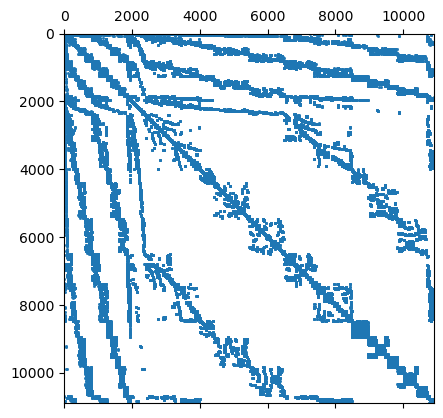

In [10]:
import matplotlib.pyplot as plt
rows,cols,vals = da.mat.COO()
import scipy.sparse as sp
A = sp.csr_matrix((vals,(rows,cols)))
plt.spy(A,markersize=1)
print(A.nnz)